# ULMFiT
For more information I recommend this [excellent post](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb).

UlmFit consists of 3 steps:
1. Training the language model on a general-domain corpus that captures high-level natural language features
1. Fine-tuning the pre-trained language model on target task data
1. Fine-tuning the classifier on target task data

![ulmfit 3 steps](https://miro.medium.com/max/1616/1*w_qNXVr7N2OPCK5iMnHAVQ.png)

Step 1 requires a lot of resources and was already performed by the creators of the FastAI package. For this task we will perform steps 2 and 3.

It puts together a few tricks for optimizing neural networks:
1. Detection of initial Learning Rate. This is done by changing the learning rate in a wide range during the first steps of a neural network training, and keeping the rate that leads to the fastest decrease of the network loss. 
1. Cyclical learning rate changes, that aim to improve convergence speed while reducing the risk of getting stuck in a local minimum
1. Transfer learning 
1. Integration of a large unlabeled dataset. This dataset is used to fine-tune the language model
1. A rather simple but effective network architecture for the classifier. This NN architecture of 3 fully connected layers is supposed to provide solid performance on a large array of text classification tasks

Using Ulmfit is rather simple

The Note that we provide the data to the language model 
`bs` is the batch size.  
We use the function `learner.lr_find()` to find the learning rate.  

The function `learner.fit_one_cycle(PARAMETERS)` 


In [1]:
from fastai import *
from fastai.text import *

In [5]:
import pandas as pd
df_trn = pd.read_csv('data/train.csv').set_index('index')
df_val = pd.read_csv('data/val.csv').set_index('index')
df_trn.head()

,level_0,data,target,label,text,num_chars
index,,,,,,
2754,1250,\n\nCheck again. You may find that the arrest...,2,talk.politics.guns,check again . you may find that the arrest war...,92
2608,1184,\n\n\tB urn\n\tA ll\n\tT he\n\tF uckers\n,2,talk.politics.guns,b urn a ll t he f uckers,24
2619,1190,\n\t[...deleted...]\n\nAt least you're consist...,2,talk.politics.guns,[ . . .deleted . . .] at least you're consiste...,273
3426,1549,"Bunker & McNally were later.\n\nPappas, Estrad...",0,rec.sport.baseball,"bunker & mcnally were later . pappas , estrada...",75
1675,765,"NJ> : >And, while we are on the subject, has a...",1,rec.sport.hockey,"nj> : >and , while we are on the subject , has...",281


In [6]:
df_trn = df_trn[['text', 'label']]
df_val = df_val[['text', 'label']]

df_trn['text'] = df_trn['text'].str.split()
df_val['text'] = df_val['text'].str.split()

In [7]:
# Language model data
print('Getting languge model data...')
data_lm = TextLMDataBunch.from_df(
    train_df=df_trn, 
    valid_df=df_val, 
    path="", 
    label_cols='label', 
    text_cols='text')

In [9]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(
    path="", 
    train_df=df_trn, 
    valid_df=df_val,
    label_cols='label', 
    text_cols='text', 
    vocab=data_lm.train_ds.vocab, 
    bs=32)


In [ ]:
if os.fileexists(''):
    data_clas = load_data(path, 'data_clas.pkl', bs=bs)
else:
    data_clas = TextClasDataBunch.from_df(
        path="", 
        train_df=df_trn, 
        valid_df=df_val,
        label_cols='label', 
        text_cols='text', 
        vocab=data_lm.train_ds.vocab, 
        bs=32)    
    data_clas.save('data_clas.pkl')

In [2]:
lm_learn = language_model_learner(
    data_lm, 
    drop_mult=0.7, 
    arch=AWD_LSTM)

# Change to float16 precision. This leads to x2-x3 speedup on modern GPUs
lm_learn = lm_learn.to_fp16(clip=0.1)
# train the learner object with learning rate = 1e-2
lm_learn.fit_one_cycle(cyc_len=1, max_lr=1e-2)
# Find the optimal learning rate
lm_learn.lr_find(start_lr=1e-07, end_lr=10)
# Plot a graph for detecting the optimal learning rate
lm_learn.recorder.plot()

lm_learn.unfreeze()
lm_learn.fit_one_cycle(cyc_len=1, max_lr=1e-2)

# 
lm_learn.save_encoder('ft_enc')

# 
classifier_learn = text_classifier_learner(data_clas, drop_mult=0.7)
# 
classifier_learn.load_encoder('ft_enc')

classifier_learn.lr_find()
classifier_learn.recorder.plot()
classifier_learn.fit_one_cycle(cyc_len=1, max_lr=1e-2)
return classifier_learn

epoch,train_loss,valid_loss,accuracy,time
0,2.068501,1.618993,0.742504,04:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: text_classifier_learner() missing 1 required positional argument: 'arch'

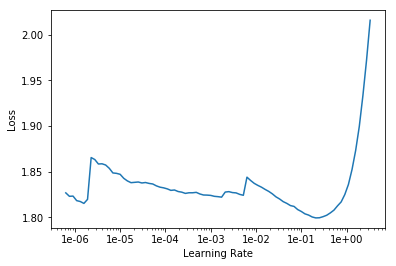

In [4]:
run_on_df(df_train, df_val)